In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
from astropy.io import fits
import pymaster as nmt
import camb
import jax_cosmo as jc

import heracles
import heracles.healpy
from heracles.notebook import Progress

import matplotlib.pyplot as plt

from mass_maping import kaiser_squire
from utils import apply_random_rotation

In [2]:
#Get mask from galaxy catalog
path_cat = '/n17data/mkilbing/astro/data/CFIS/v1.0/SP_LFmask/unions_shapepipe_2022_v1.3_mtheli8k.fits'
cat_gal = fits.getdata(path_cat)

ra = cat_gal['RA']
dec = cat_gal['DEC']
w = cat_gal['w']

theta = (90 - dec) * np.pi / 180
phi = ra * np.pi / 180
pix = hp.ang2pix(512, theta, phi)

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
n_gal = np.zeros(hp.nside2npix(512))
n_gal[unique_pix] += np.bincount(idx_rep, weights=w)
mask = n_gal != 0

In [3]:
cat_gal

FITS_rec([(108.60943 , 57.750675, -0.30161136, -0.2081118 , 2.1740813, 23.491985, 1.),
          (108.66231 , 57.751358,  0.03475485,  0.17270616, 1.5953106, 23.253155, 1.),
          (108.22295 , 57.75059 ,  0.14923581,  0.7372608 , 3.529264 , 21.768272, 1.),
          ...,
          (106.92797 , 69.71885 ,  0.02565527,  0.04950662, 4.004164 , 20.584743, 7.),
          (107.75726 , 69.716415,  0.21736535,  0.02887219, 4.1428857, 18.979   , 7.),
          (106.719406, 69.719666, -0.15008399, -0.24350959, 1.8469388, 23.761492, 7.)],
         dtype=(numpy.record, [('RA', '>f4'), ('Dec', '>f4'), ('e1', '>f4'), ('e2', '>f4'), ('w', '>f4'), ('mag', '>f4'), ('patch', '>f4')]))

In [5]:
num_sim = 2
path_output = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}.npy'
output = np.load(path_output, allow_pickle=True).item()

### Analyze the simulated gamma and noise maps

In [6]:
gamma_map = output['masked_shear_map']
noise_map = output['noise_map']

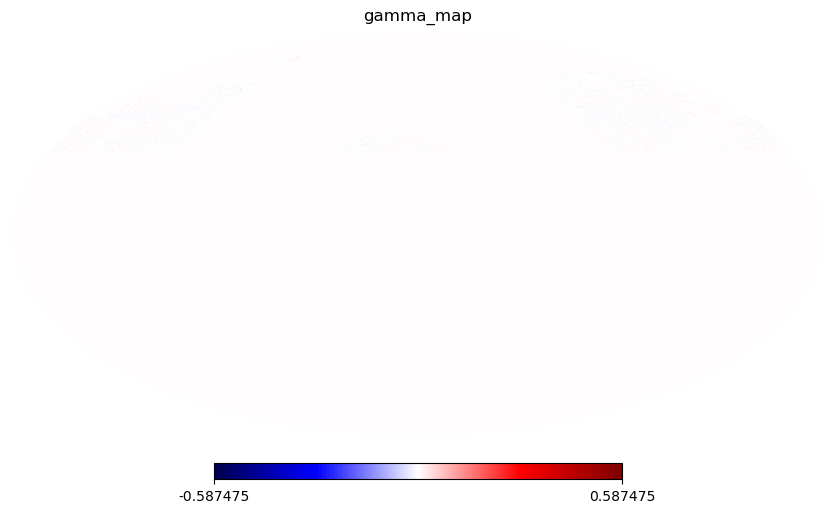

In [7]:
min = -np.max([np.abs(np.min(gamma_map.real)), np.max(gamma_map.real)])
max = np.max([np.abs(np.min(gamma_map.real)), np.max(gamma_map.real)])
hp.mollview(gamma_map.real, title='gamma_map', cmap='seismic', min=min, max=max)
plt.show()

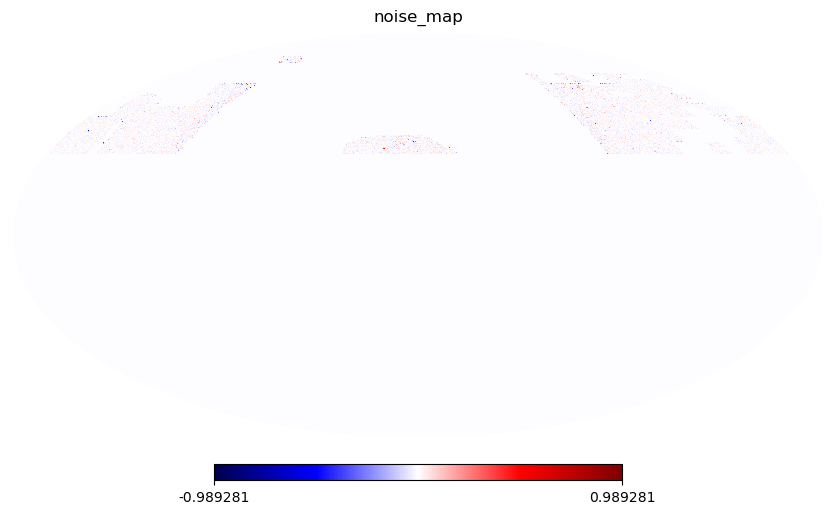

In [8]:
min = -np.max([np.abs(np.min(noise_map.real)), np.max(noise_map.real)])
max = np.max([np.abs(np.min(noise_map.real)), np.max(noise_map.real)])
hp.mollview(noise_map.real, title='noise_map', cmap='seismic', min=min, max=max)
plt.show()

In [9]:
shear_map = gamma_map + noise_map

In [10]:
kappa_E, kappa_B = kaiser_squire(shear_map)

/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: invalid value encountered in multiply
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: invalid value encountered in multiply


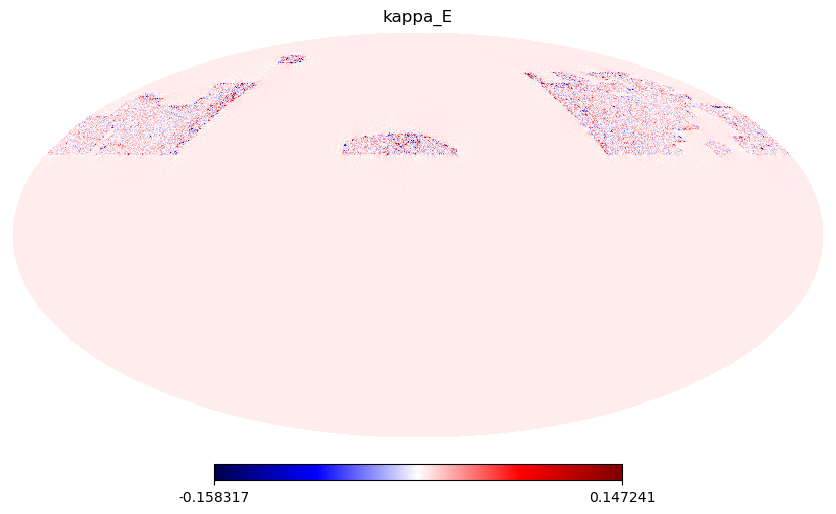

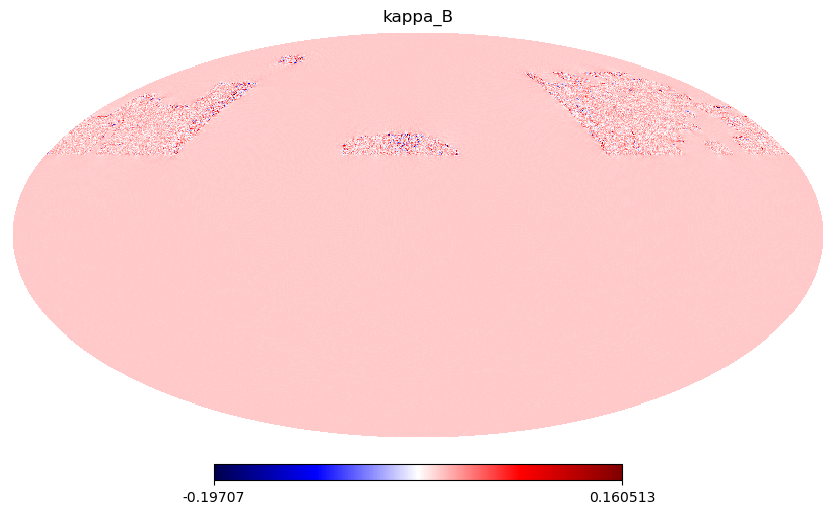

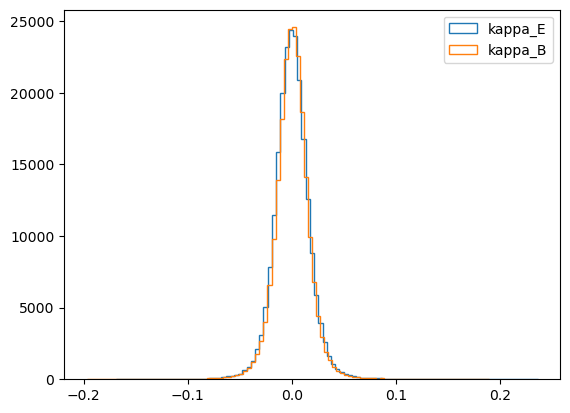

In [11]:
hp.mollview(kappa_E, title='kappa_E', cmap='seismic')
plt.show()

hp.mollview(kappa_B, title='kappa_B', cmap='seismic')
plt.show()

plt.figure()

plt.hist(kappa_E[mask], bins=100, histtype='step', label='kappa_E')
plt.hist(kappa_B[mask], bins=100, histtype='step', label='kappa_B')

plt.legend()

plt.show()

There is some leakage in the $\kappa_B$ map due to the noise.

In [12]:
kappa_map_E, kappa_map_B = kaiser_squire(gamma_map)

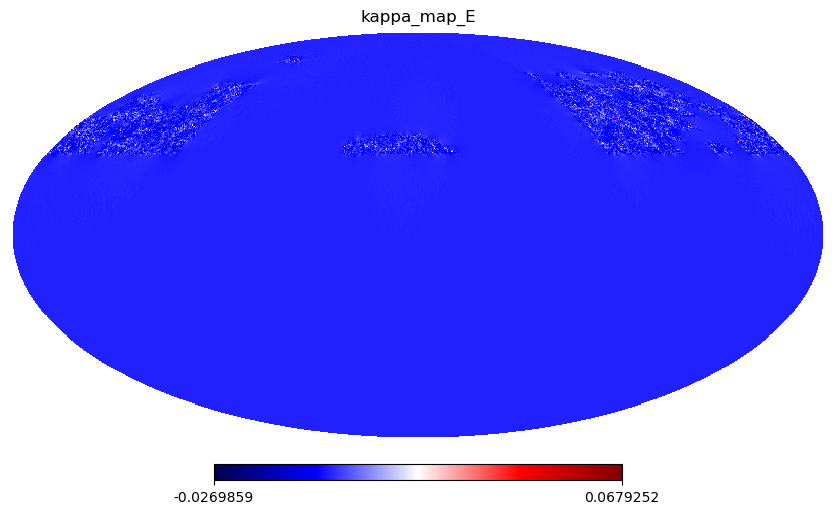

In [13]:
hp.mollview(kappa_map_E, title='kappa_map_E', cmap='seismic')
plt.show()

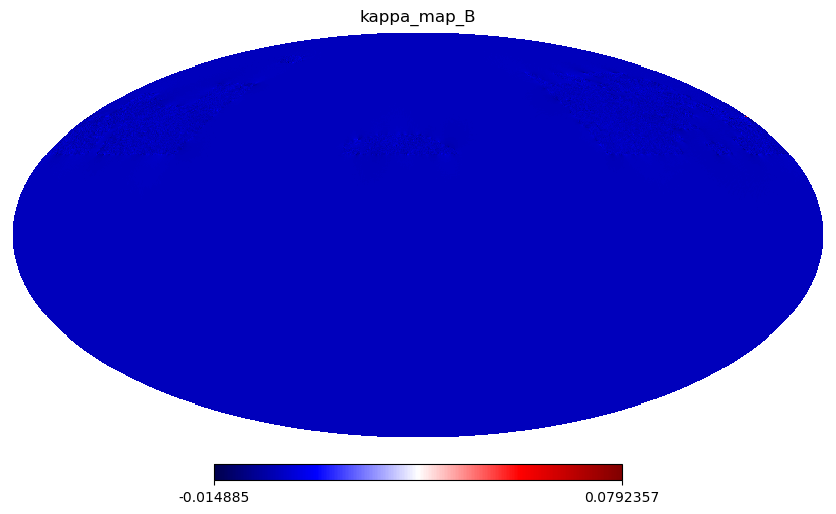

In [14]:
hp.mollview(kappa_map_B, title='kappa_map_B', cmap='seismic')
plt.show()

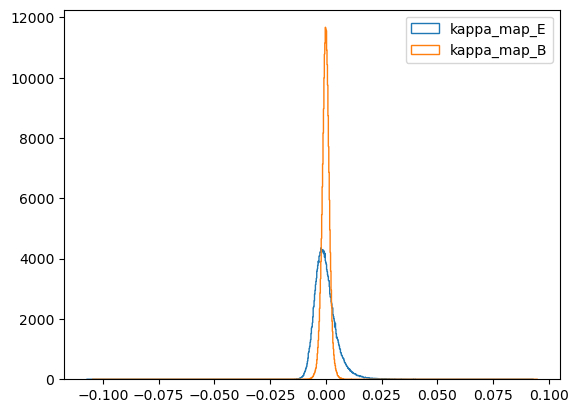

In [15]:
plt.figure()

plt.hist(kappa_map_E[mask], bins=1000, histtype='step', label='kappa_map_E')
plt.hist(kappa_map_B[mask], bins=1000, histtype='step', label='kappa_map_B')

plt.legend()
#plt.xlim(-0.01, 0.01)

plt.show()

When looking only at the gamma map we see that B modes appear due to border effects with the mask but the signal is really contained in the E mode.

In [16]:
gamma_obs_e1 = np.zeros(hp.nside2npix(512))
gamma_obs_e2 = np.zeros(hp.nside2npix(512)) 

gamma_obs_e1[unique_pix] += np.bincount(idx_rep, weights=w * cat_gal['e1'])
gamma_obs_e2[unique_pix] += np.bincount(idx_rep, weights=w * cat_gal['e2'])

gamma_obs_e1[mask] /= n_gal[mask]
gamma_obs_e2[mask] /= n_gal[mask]

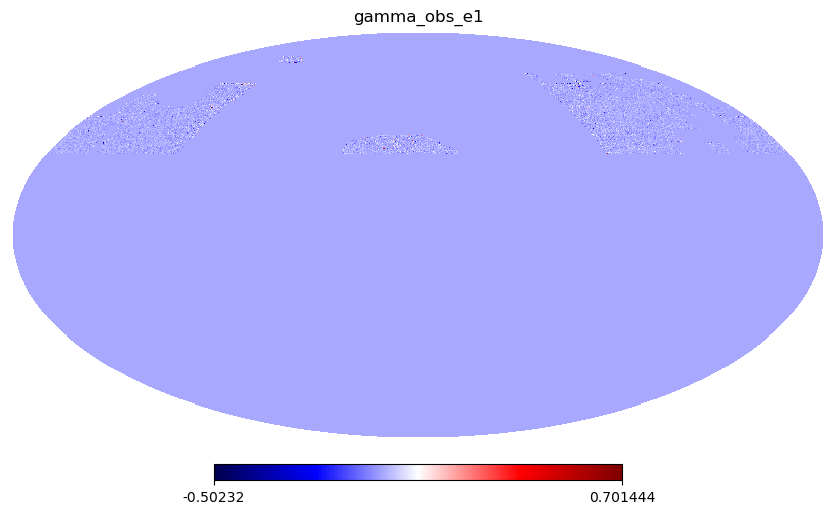

In [17]:
hp.mollview(gamma_obs_e1, title='gamma_obs_e1', cmap='seismic')
plt.show()

In [18]:
kappa_obs_E, kappa_obs_B = kaiser_squire(gamma_obs_e1 +1j* gamma_obs_e2)

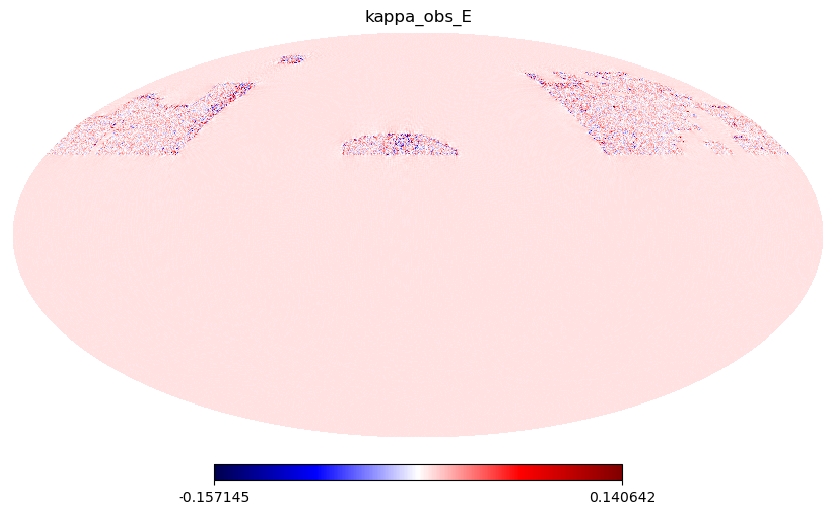

In [19]:
hp.mollview(kappa_obs_E, title='kappa_obs_E', cmap='seismic')
plt.show()

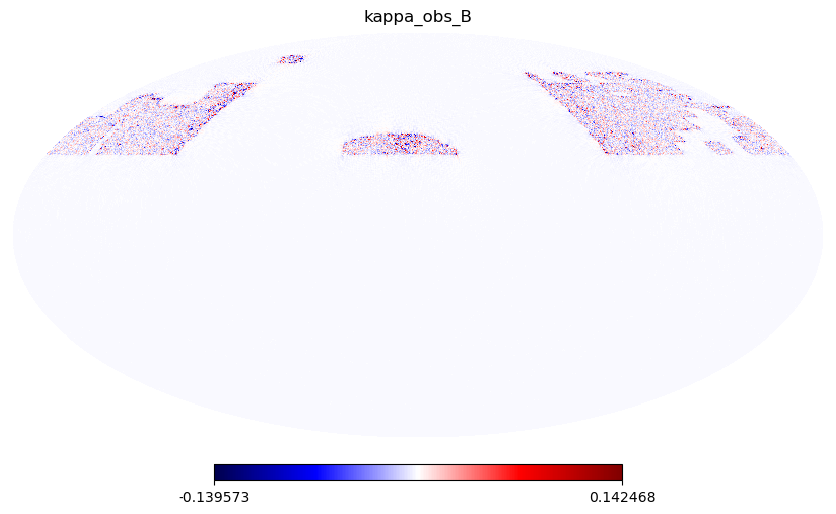

In [20]:
hp.mollview(kappa_obs_B, title='kappa_obs_B', cmap='seismic')
plt.show()

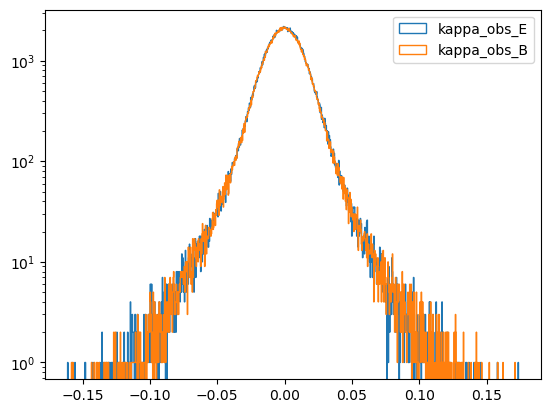

In [21]:
plt.figure()

plt.hist(kappa_obs_E[mask], bins=1000, histtype='step', label='kappa_obs_E')
plt.hist(kappa_obs_B[mask], bins=1000, histtype='step', label='kappa_obs_B')

plt.legend()
plt.yscale('log')

plt.show()

We obtain very similar results on real data.

### Analyze the mass maping on the full sky map

In [22]:
full_sky_gamma = np.load(f'/n17data/sguerrini/GowerStreetSims/processed/gamma_lensing_bar_sim{num_sim:05d}.npy')

In [23]:
kappa_E_fs, kappa_B_fs = kaiser_squire(full_sky_gamma)

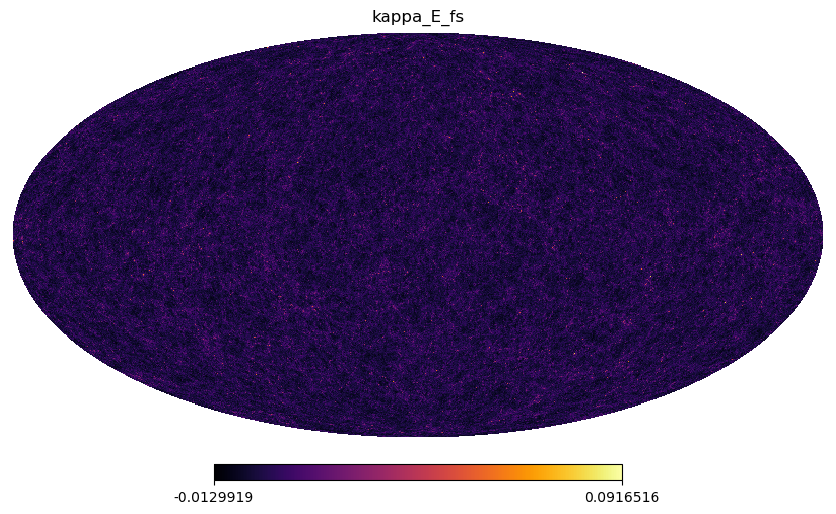

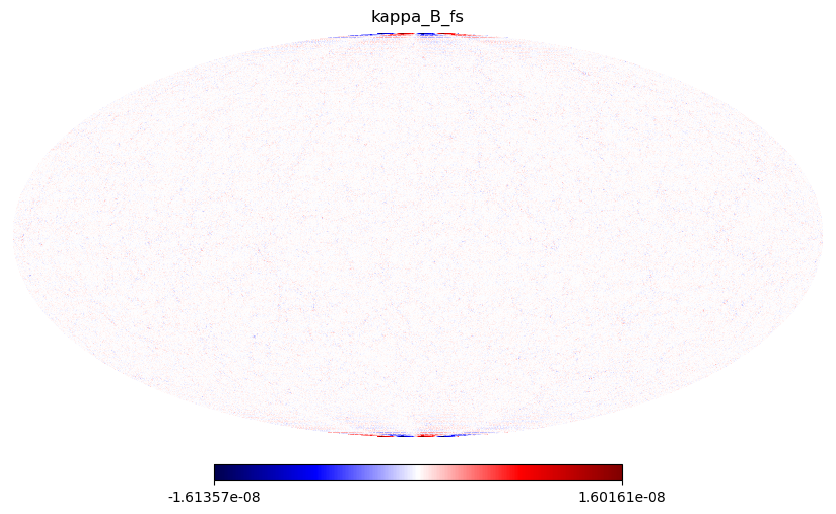

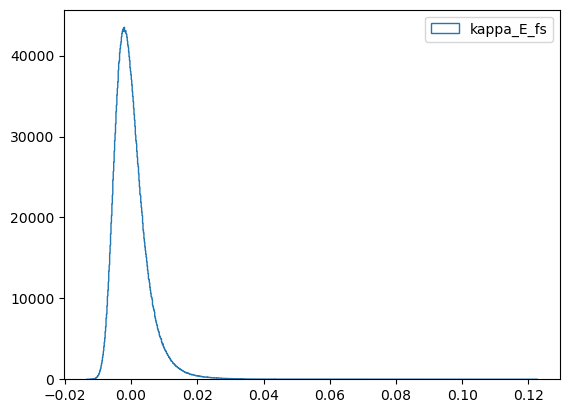

In [24]:
hp.mollview(kappa_E_fs, title='kappa_E_fs', cmap='inferno')
plt.show()

hp.mollview(kappa_B_fs, title='kappa_B_fs', cmap='seismic')
plt.show()

plt.figure()

plt.hist(kappa_E_fs, bins=1000, histtype='step', label='kappa_E_fs')
#plt.hist(kappa_B_fs, bins=1000, histtype='step', label='kappa_B_fs')

plt.legend()

plt.show()

The B modes are negligible in the case of a full sky map (which makes sense since KS is exact for a full-sky map).

### Computation of the power spectrum of the convergence map

In [24]:
#Measure the pseudo-Cls on the shear map (noiseless)
f_0a = nmt.NmtField(mask, [shear_map.real, shear_map.imag])

b = nmt.NmtBin.from_nside_linear(512, 10)

cl = nmt.compute_full_master(f_0a, f_0a, b)

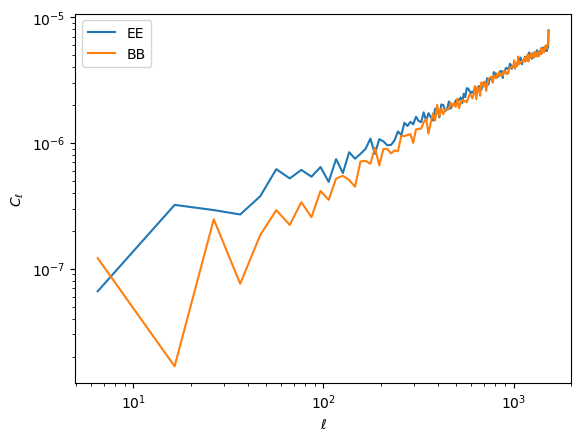

In [25]:
ell_ar = b.get_effective_ells()

plt.plot(ell_ar, ell_ar*cl[0], label='EE')
plt.plot(ell_ar, ell_ar*cl[3], label='BB')
plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend()

plt.show()

In [26]:
from utils import read_cosmo_params

path_info = '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv'

cosmo_params = read_cosmo_params(path_info, sim=1)

In [27]:
#Comparison with the power spectrum

#Load parameters for the cosmology
h = cosmo_params["h"]
Om = cosmo_params["Omega_m"]
Ob = cosmo_params["Omega_b"]
Oc = Om - Ob
ns = cosmo_params["n_s"]
m_nu = cosmo_params["m_nu"]
w = cosmo_params["w"]
As = cosmo_params["A_s"]

nside=512
lmax = 2*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
Onu = pars.omeganu
Oc = Om - Ob - Onu
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, omnuh2=Onu*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)

path_redshift = '/n17data/mkilbing/astro/data/CFIS/v1.0/nz/dndz_SP_A.txt'
z, dndz = np.loadtxt(path_redshift, unpack=True)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)


/tmp/ipykernel_629206/3288218533.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, lmax)


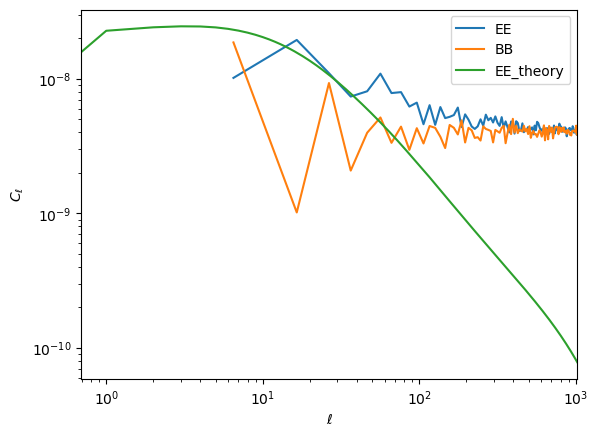

In [28]:
ell_ar = b.get_effective_ells()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

plt.plot(ell_ar, cl[0], label='EE')
plt.plot(ell_ar, cl[3], label='BB')
plt.plot(np.arange(lmax+1), theory_cls['W1xW1']*pw**2, label='EE_theory')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend()

plt.xlim(0, lmax)
plt.show()

In [29]:
plt.figure()

plt.plot(ell_ar, cl[0] / theory_cls['W1xW1'], label='EE')

ValueError: operands could not be broadcast together with shapes (153,) (1025,) 

<Figure size 640x480 with 0 Axes>

In [ ]:
nside = 512
lmax = 2*nside

In [ ]:
mapper = heracles.healpy.HealpixMapper(nside, lmax)

In [ ]:
fields = {
    "G": heracles.Shears(
        mapper,
        "RA",
        "Dec",
        "e1",
        "e2",
        "w",
        mask="w"
    )
}

In [ ]:
cat_gal = heracles.FitsCatalog(path_cat)
catalogs = {1: cat_gal}

with Progress("mapping") as progress:
    data = heracles.map_catalogs(fields, catalogs, parallel=True, progress=progress)

VBox()

In [ ]:
list(data.keys())

[('G', 1)]

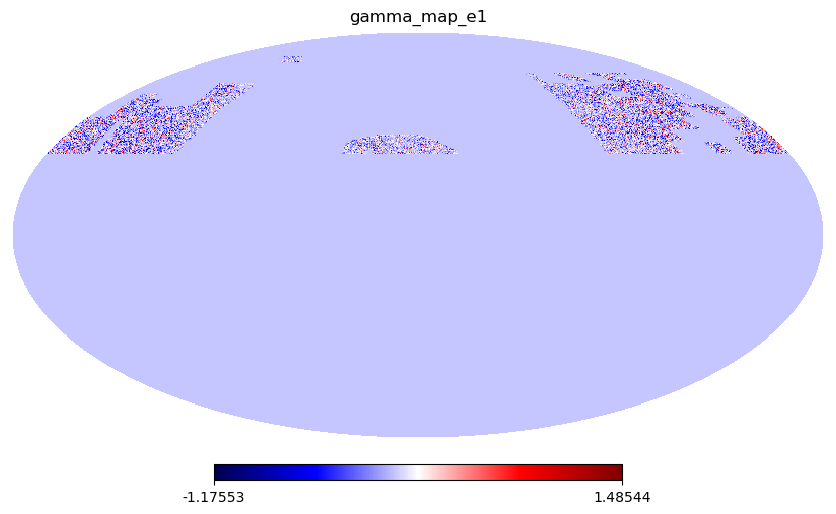

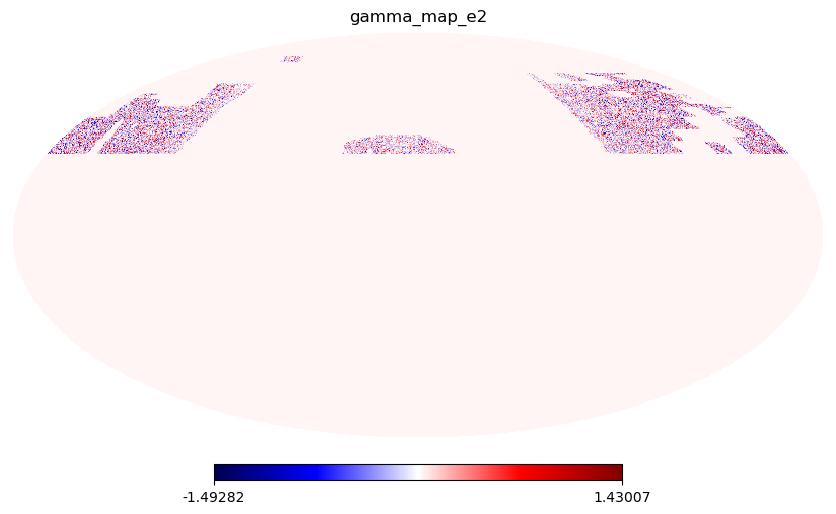

In [ ]:
hp.mollview(data['G', 1][0], cmap='seismic', title='gamma_map_e1')
plt.show()

hp.mollview(data['G', 1][1], cmap='seismic', title='gamma_map_e2')
plt.show()

In [ ]:
with Progress("transform") as progress:
    alms = heracles.transform(fields, data, progress=progress)

VBox()

In [ ]:
cls_heracles = heracles.angular_power_spectra(alms)

In [ ]:
list(cls_heracles.keys())

[('G_E', 'G_E', 1, 1), ('G_E', 'G_B', 1, 1), ('G_B', 'G_B', 1, 1)]

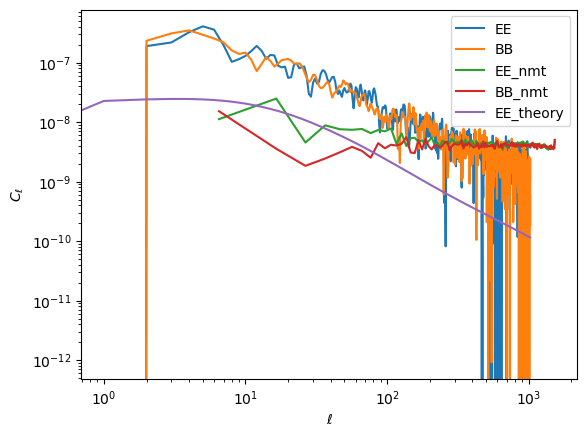

In [ ]:
ell = np.arange(lmax+1)

plt.figure()

plt.plot(ell, cls_heracles['G_E', 'G_E', 1, 1], label='EE')
plt.plot(ell, cls_heracles['G_B', 'G_B', 1, 1], label='BB')

plt.plot(ell_ar, cl[0], label='EE_nmt')
plt.plot(ell_ar, cl[3], label='BB_nmt')

plt.plot(np.arange(lmax+1), theory_cls['W1xW1'], label='EE_theory')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

